In [31]:
from common.inputreader import InputReader, PuzzleWrapper

puzzle = PuzzleWrapper(year=int("2024"), day=int("24"))

puzzle.header()

# Crossed Wires

[Open Website](https://adventofcode.com/2024/day/24)

In [32]:
# helper functions
class Connection:
    def __init__(self, id: int, inputs: tuple, operation: str, output: str):
        self.inputs = inputs
        self.operation = operation
        self.output = output
        self.can_calculate = False
        self.id = id

    def __str__(self):
        return f"{self.id}: {self.inputs} {self.operation} {self.output}"


def domain_from_input(input: InputReader) -> tuple:
    lines = input.lines_as_strs()

    wires = {}
    connections = []

    reading_registers = True
    counter = 0
    for line in lines:
        if len(line) == 0:
            reading_registers = False
            continue

        if reading_registers:
            # trim last character of line[0]
            wire = line[0][:-1]
            wires[wire] = int(line[1])
        else:
            inputs = (line[0], line[2])
            operation = line[1]
            output = line[4]
            connection = Connection(counter, inputs, operation, output)
            connections.append(connection)
            counter += 1

    return wires, connections


test_input, test_connections = domain_from_input(puzzle.example(0))
print(test_input, test_connections)

{'x00': 1, 'x01': 1, 'x02': 1, 'y00': 0, 'y01': 1, 'y02': 0} [<__main__.Connection object at 0x107afcad0>, <__main__.Connection object at 0x10c5e87d0>, <__main__.Connection object at 0x10c5e8190>]


In [33]:



# test case (part 1)

def draw_graph(graph):
    pos = nx.spring_layout(graph)
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold',
            arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')
    plt.show()


def calculate_result(wires, start) -> (int, list):
    # find wires that start with z
    subset_wires = [wire for wire in wires if wire.startswith(start)]
    # sort wires alphabetically
    subset_wires = sorted(subset_wires, reverse=True)
    subset_wire_values = [wires[wire] for wire in subset_wires]
    # concatenate values as a string and convert from binary to decimal
    return int("".join([str(value) for value in subset_wire_values]), 2), subset_wire_values


def part_1(reader: InputReader, debug: bool) -> int:
    wires, connections = domain_from_input(reader)

    graph = nx.DiGraph()

    for connection in connections:
        graph.add_edge(connection.inputs[0], connection.output)
        graph.add_edge(connection.inputs[1], connection.output)

    # copy connections to queue
    queue = connections.copy()

    while len(queue) > 0:
        # mark connections that can be calculated
        for connection in queue:
            inputs = connection.inputs
            connection.can_calculate = all([input in wires for input in inputs])
        # sort by can_calculate
        queue.sort(key=lambda x: x.can_calculate, reverse=True)

        # calculate connection
        connection = queue.pop(0)

        inputs = connection.inputs
        input_values = [wires[input] for input in inputs]

        if connection.operation == "AND":
            wires[connection.output] = input_values[0] & input_values[1]
        elif connection.operation == "OR":
            wires[connection.output] = input_values[0] | input_values[1]
        elif connection.operation == "XOR":
            wires[connection.output] = input_values[0] ^ input_values[1]

    total, _ = calculate_result(wires, "z")
    return total


result = part_1(puzzle.example(0), True)
print(result)
assert result == 4

result = part_1(puzzle.get_code_block(1), True)
print(result)
assert result == 2024

4
2024


In [34]:
# real case (part 1)
result = part_1(puzzle.input(), False)
print(result)
assert result == 51715173446832

51715173446832


In [35]:

from itertools import combinations


# test case (part 2)
def run(wires, connections):
    wires = wires.copy()
    # copy connections to queue
    queue = connections.copy()

    while len(queue) > 0:
        # mark connections that can be calculated
        for connection in queue:
            inputs = connection.inputs
            connection.can_calculate = all([input in wires for input in inputs])
        # sort by can_calculate
        queue.sort(key=lambda x: x.can_calculate, reverse=True)

        # calculate connection
        connection = queue.pop(0)

        inputs = connection.inputs
        input_values = [wires[input] for input in inputs]

        if connection.operation == "AND":
            wires[connection.output] = input_values[0] & input_values[1]
        elif connection.operation == "OR":
            wires[connection.output] = input_values[0] | input_values[1]
        elif connection.operation == "XOR":
            wires[connection.output] = input_values[0] ^ input_values[1]

    return wires


def test_wires(wires) -> bool:
    _, x_values = calculate_result(wires, "x")
    _, y_values = calculate_result(wires, "y")
    _, z_values = calculate_result(wires, "z")

    # perform binary addition of x and y
    solution = []
    for i in range(len(x_values)):
        solution.append(x_values[i] & y_values[i])

    return solution == z_values


def part_2(reader: InputReader, pair_count: int, debug: bool) -> int:
    initial_wires, connections = domain_from_input(reader)
    connection_map = {connection.id: connection for connection in connections}

    if debug:
        print(f"Initial wires: {initial_wires} and connections: {connections}")

    # find all the pairs of connections
    pairs = list(combinations(connection_map.values(), 2))

    def generate_sets(pairs, pair_count):
        for set in combinations(pairs, pair_count):
            yield set

    def swap_pair(pair):
        connection1, connection2 = pair
        id1, id2 = connection1.id, connection2.id
        connection_map[id1].output, connection_map[id2].output = connection_map[id2].output, connection_map[id1].output

    def swap_set(set):
        for pair in set:
            swap_pair(pair)

    tested_pairs = []

    for next_set in generate_sets(pairs, pair_count):

        outputs = []
        original_map = {}
        for pair in next_set:
            pair = sorted(pair, key=lambda x: x.output)
            connection1, connection2 = pair
            outputs.append(connection1.output)
            outputs.append(connection2.output)
            original_map[connection1.id] = connection1.output
            original_map[connection2.id] = connection2.output

        if len(set(outputs)) != pair_count * 2:
            continue

        current_set = ",".join(sorted(outputs))

        if outputs in tested_pairs:
            continue
        tested_pairs.append(outputs)

        # for each pair of pairs, swap the outputs
        swap_set(next_set)

        # run the connections
        result = run(initial_wires, list(connection_map.values()))
        if test_wires(result):
            return current_set

        # swap back    
        for id, value in original_map.items():
            connection_map[id].output = value

    raise Exception("No solution found")


result = part_2(puzzle.get_code_block(5), 2, True)
print(result)
assert result == "z00,z01,z02,z05"

Initial wires: {'x00': 0, 'x01': 1, 'x02': 0, 'x03': 1, 'x04': 0, 'x05': 1, 'y00': 0, 'y01': 0, 'y02': 1, 'y03': 1, 'y04': 0, 'y05': 1} and connections: [<__main__.Connection object at 0x10c5c51d0>, <__main__.Connection object at 0x10c5c5240>, <__main__.Connection object at 0x10c5c5320>, <__main__.Connection object at 0x10d09add0>, <__main__.Connection object at 0x10d099b00>, <__main__.Connection object at 0x10d09aa50>]
z00,z01,z02,z05


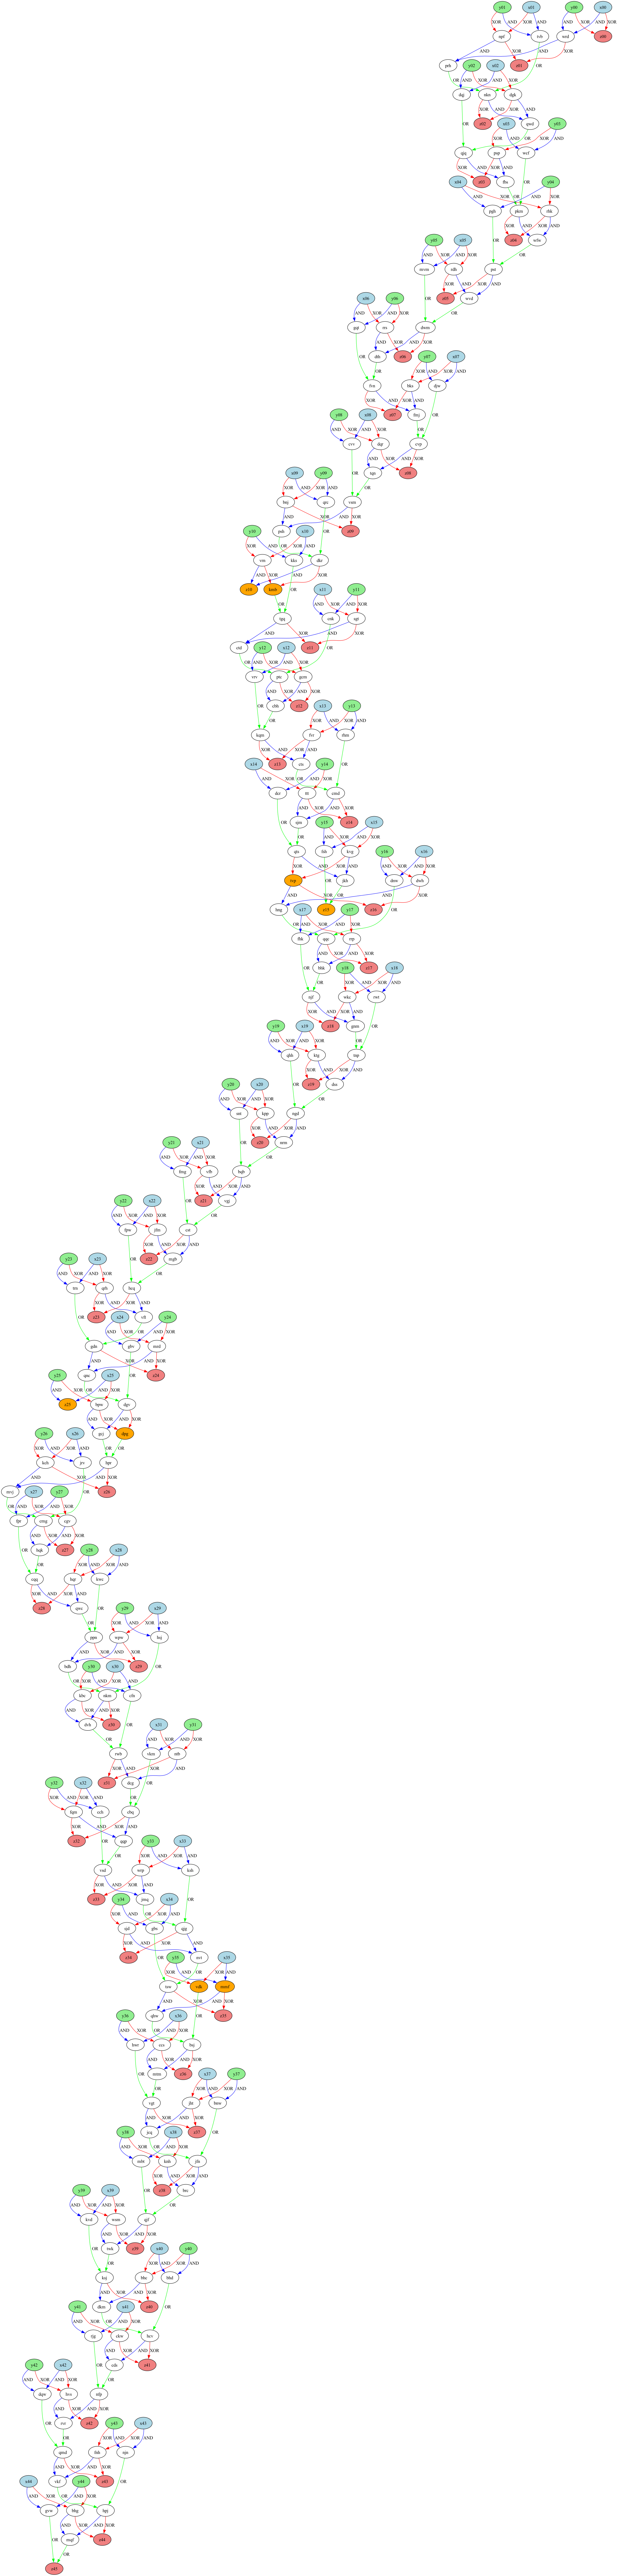

In [62]:
import pydot
from IPython.display import Image, display
import io


def build_visual():
    wires, operations = domain_from_input(puzzle.input())
    # build directed graph including operations
    graph = pydot.Dot(graph_type='digraph', rankdir='TB')

    node_colors = {
        'x': 'lightblue',
        'y': 'lightgreen',
        'z': 'lightcoral'
    }

    wrong = [
        "dpg",
        "kmb",
        "mmf",
        "tvp",
        "vdk",
        "z10",
        "z15",
        "z25"
    ]

    def get_node_color(node):
        if node in wrong:
            return 'orange'
        return node_colors.get(node[0], 'white')

    for operation in operations:
        input1, input2 = operation.inputs
        output = operation.output
        operation_type = operation.operation

        # Add nodes with colors
        graph.add_node(pydot.Node(input1, style='filled', fillcolor=get_node_color(input1)))
        graph.add_node(pydot.Node(input2, style='filled', fillcolor=get_node_color(input2)))
        graph.add_node(pydot.Node(output, style='filled', fillcolor=get_node_color(output)))

        # Add edges with labels and colors
        edge_color = 'blue' if operation_type == 'AND' else 'green' if operation_type == 'OR' else 'red'
        graph.add_edge(pydot.Edge(input1, output, label=operation_type, color=edge_color))
        graph.add_edge(pydot.Edge(input2, output, label=operation_type, color=edge_color))

    # Render the graph to a PNG image in memory
    png_str = graph.create_png()
    sio = io.BytesIO(png_str)
    display(Image(sio.getvalue()))


# Call the function to plot and display the graph inline
build_visual()

In [36]:
def part_2(reader: InputReader, debug: bool) -> str:
    wires, operations = domain_from_input(reader)
    output = run(wires, operations)
    highest_z = sorted([wire for wire in output.keys() if wire.startswith("z")])[-1]

    wrong = set()
    for operation in operations:
        input1, input2 = operation.inputs
        operation_type = operation.operation
        output = operation.output

        # everything but the last z should be an XOR
        if output[0] == "z" and operation_type != "XOR" and output != highest_z:
            wrong.add(output)

        # all the internal operations should not be an XOR
        elif (
                operation_type == "XOR"
                and output[0] not in ["x", "y", "z"]
                and input1[0] not in ["x", "y", "z"]
                and input2[0] not in ["x", "y", "z"]
        ):
            wrong.add(output)

        # all the internal operations should not be an AND, except for x00
        elif operation_type == "AND" and "x00" not in operation.inputs:
            for suboperation in operations:
                if (output in suboperation.inputs) and suboperation.operation != "OR":
                    wrong.add(output)

        # all the internal operations should not be an OR
        elif operation_type == "XOR":
            for suboperation in operations:
                if (output in suboperation.inputs) and suboperation.operation == "OR":
                    wrong.add(output)

    return ",".join(sorted(wrong))


result = part_2(puzzle.input(), False)
print(result)
assert result == 'dpg,kmb,mmf,tvp,vdk,z10,z15,z25'

dpg,kmb,mmf,tvp,vdk,z10,z15,z25


In [37]:
# print easters eggs
puzzle.print_easter_eggs()

## Easter Eggs

<span title="ENHANCE">forensic analysis</span> (ENHANCE)